# California Water Conservation 
# Time Series and Linear Regression
---
The modeling done here was mostly spent verifying the low impact of low-correlation data on water production. Due to time restraints, I deemed it was a better use of time to learn more about the replenishment of California’s water resources and the legal structures around California’s water rights, as those have a considerably greater impact on the state’s water shortage than the relatively steady rates of water production modeled here

#### Imports 

In [407]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import datetime as dt
import time
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR

from tqdm import tqdm
sns.set(style="ticks", context="talk")
plt.style.use("fivethirtyeight")

In [408]:
water = pd.read_csv('./cleaned_datasets/water_suppliers.csv')
counties = pd.read_csv('./cleaned_datasets/counties.csv')
hydro_regions = pd.read_csv('./cleaned_datasets/hydrologic_regions.csv')
suppliers = pd.read_csv('./cleaned_datasets/supplier_names.csv')
conserve = pd.read_csv('./cleaned_datasets/conservation.csv')
rain = pd.read_csv('./cleaned_datasets/rainfall.csv')

---
## Water Suppliers
---

In [409]:
hydro_regions['hydrologic_region'].to_dict()

{0: 'San Francisco Bay',
 1: 'Central Coast',
 2: 'South Coast',
 3: 'San Joaquin River',
 4: 'Sacramento River',
 5: 'Colorado River',
 6: 'North Coast',
 7: 'Tulare Lake',
 8: 'South Lahontan',
 9: 'North Lahontan'}

In [410]:
water.head()

,climate_zone,total_population_served,reference_2014_population,water_shortage_contingency_stage_invoked,reported_final_total_potable_water_production,final_percent_residential_use,reported_final_commercial_industrial_and_institutional_water,calculated_total_potable_water_production_gallons_ag_excluded,calculated_total_potable_water_production_gallons_2013_ag_excluded,calculated_commercial_agricultural_water_gallons,calculated_commercial_agricultural_water_gallons_2013,calculated_r_gpcd,system_id,county_enc,hydro_region_enc,reporting_date
0,3,1400000.0,1379000.0,0.0,2.877158e+13,69.734913,6.977072e+12,4.964000e+09,5.418000e+09,0.0,0.0,73.2781,110005,0,0,2021-04-15
1,3,1400000.0,1379000.0,0.0,2.877158e+13,69.734913,6.977072e+12,4.221000e+09,4.928000e+09,0.0,0.0,59.3274,110005,0,0,2021-03-15
2,3,1400000.0,1379000.0,0.0,2.877158e+13,69.734913,6.977072e+12,3.549000e+09,4.016000e+09,0.0,0.0,55.2268,110005,0,0,2021-02-15
3,3,1400000.0,1379000.0,0.0,2.877158e+13,69.734913,6.977072e+12,3.919000e+09,4.099000e+09,0.0,0.0,55.9857,110005,0,0,2021-01-15
4,3,1450000.0,1379000.0,0.0,4.169200e+09,60.000000,5.790000e+08,4.169000e+09,4.772000e+09,0.0,0.0,55.6485,110005,0,0,2020-12-15


In [411]:
water.shape

(32425, 16)

In [412]:
water.dtypes

climate_zone                                                            int64
total_population_served                                               float64
reference_2014_population                                             float64
water_shortage_contingency_stage_invoked                              float64
reported_final_total_potable_water_production                         float64
final_percent_residential_use                                         float64
reported_final_commercial_industrial_and_institutional_water          float64
calculated_total_potable_water_production_gallons_ag_excluded         float64
calculated_total_potable_water_production_gallons_2013_ag_excluded    float64
calculated_commercial_agricultural_water_gallons                      float64
calculated_commercial_agricultural_water_gallons_2013                 float64
calculated_r_gpcd                                                     float64
system_id                                                       

In [413]:
water['reporting_date'] = pd.to_datetime(water['reporting_date'])
water['reporting_date'].dt.year.value_counts(normalize=True)

2016    0.151149
2015    0.150470
2017    0.149946
2018    0.141804
2020    0.136962
2019    0.134495
2014    0.086847
2021    0.048327
Name: reporting_date, dtype: float64

In [414]:
# water['reporting_date'] = pd.to_datetime(water['reporting_date'])
water['reporting_date'].dt.month.value_counts(normalize=True)

9     0.085428
10    0.085305
11    0.085058
1     0.084626
12    0.084595
2     0.084472
7     0.084040
3     0.083948
8     0.083886
6     0.083577
4     0.083331
5     0.071735
Name: reporting_date, dtype: float64

---
---

In [415]:
water

,climate_zone,total_population_served,reference_2014_population,water_shortage_contingency_stage_invoked,reported_final_total_potable_water_production,final_percent_residential_use,reported_final_commercial_industrial_and_institutional_water,calculated_total_potable_water_production_gallons_ag_excluded,calculated_total_potable_water_production_gallons_2013_ag_excluded,calculated_commercial_agricultural_water_gallons,calculated_commercial_agricultural_water_gallons_2013,calculated_r_gpcd,system_id,county_enc,hydro_region_enc,reporting_date
0,3,1400000.0,1.379000e+06,0.0,2.877158e+13,69.734913,6.977072e+12,4.964000e+09,5.418000e+09,0.0,0.000000e+00,73.2781,110005,0,0,2021-04-15
1,3,1400000.0,1.379000e+06,0.0,2.877158e+13,69.734913,6.977072e+12,4.221000e+09,4.928000e+09,0.0,0.000000e+00,59.3274,110005,0,0,2021-03-15
2,3,1400000.0,1.379000e+06,0.0,2.877158e+13,69.734913,6.977072e+12,3.549000e+09,4.016000e+09,0.0,0.000000e+00,55.2268,110005,0,0,2021-02-15
3,3,1400000.0,1.379000e+06,0.0,2.877158e+13,69.734913,6.977072e+12,3.919000e+09,4.099000e+09,0.0,0.000000e+00,55.9857,110005,0,0,2021-01-15
4,3,1450000.0,1.379000e+06,0.0,4.169200e+09,60.000000,5.790000e+08,4.169000e+09,4.772000e+09,0.0,0.000000e+00,55.6485,110005,0,0,2020-12-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32420,6,11712.0,8.948902e+04,1.0,5.888128e+07,50.000000,2.766475e+07,5.897911e+07,4.438801e+08,0.0,5.588803e+06,83.9297,1910149,3,2,2020-09-15
32421,11,10312.0,1.091100e+04,1.0,5.790483e+07,79.170000,1.061860e+07,5.790446e+07,5.659993e+07,0.0,5.588803e+06,148.1860,410008,40,4,2021-04-15
32422,11,10312.0,1.091100e+04,1.0,3.440839e+07,83.210000,5.733819e+06,3.440814e+07,3.914072e+07,0.0,5.588803e+06,89.5637,410008,40,4,2021-03-15
32423,11,10312.0,1.091100e+04,1.0,2.944605e+07,85.290000,3.995346e+06,2.944632e+07,2.890350e+07,0.0,5.588803e+06,86.9818,410008,40,4,2021-02-15


In [416]:
water.reporting_date.nunique()/12

6.916666666666667

In [417]:
water.dtypes

climate_zone                                                                   int64
total_population_served                                                      float64
reference_2014_population                                                    float64
water_shortage_contingency_stage_invoked                                     float64
reported_final_total_potable_water_production                                float64
final_percent_residential_use                                                float64
reported_final_commercial_industrial_and_institutional_water                 float64
calculated_total_potable_water_production_gallons_ag_excluded                float64
calculated_total_potable_water_production_gallons_2013_ag_excluded           float64
calculated_commercial_agricultural_water_gallons                             float64
calculated_commercial_agricultural_water_gallons_2013                        float64
calculated_r_gpcd                                                

In [418]:
def region_series(region, col, interval='M'):
    """
    """
    regions = {b: a for a, b in hydro_regions['hydrologic_region'].to_dict().items()}
    regional = water[water['hydro_region_enc'] == regions[region]]
    regional = regional.set_index('reporting_date')
    regional = pd.DataFrame(regional.resample(interval)[col].sum())
    return regional 
    

In [419]:
region_series('Central Coast', ['calculated_r_gpcd', 'reported_final_total_potable_water_production'])

,calculated_r_gpcd,reported_final_total_potable_water_production
reporting_date,,
2014-06-30,3336.0799,5.604272e+09
2014-07-31,3408.2346,5.939228e+09
2014-08-31,3093.8521,5.393243e+09
2014-09-30,3144.0012,5.215423e+09
2014-10-31,2918.9663,4.989570e+09
...,...,...
2020-12-31,2273.4135,1.875414e+13
2021-01-31,2065.8768,6.627573e+13
2021-02-28,2108.4001,5.690018e+13


In [420]:
# Code written by Joseph Nelson.

def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

interpret_dftest(adfuller(region_series('Central Coast', 'calculated_r_gpcd').diff().dropna()))

Test Statistic   -2.887279
p-value           0.046847
dtype: float64

In [421]:
train, test = train_test_split(region_series('Central Coast', 'calculated_r_gpcd'),
                                  test_size=0.1, 
                                  shuffle=False)

In [422]:
sarimax = SARIMAX(endog=train.astype(float).dropna(), 
                  order = (2, 1, 1),
                  seasonal_order=(1, 0, 1, 12))
sarimax_model = sarimax.fit()
preds = sarimax_model.predict(start = test.index[0], end= test.index[-1])

/Users/rylandmatthews/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/rylandmatthews/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [423]:
mean_squared_error(test, preds, squared=False)

290.8654137435059

In [424]:
mean_squared_error(test, preds, squared=False) / test.mean()

calculated_r_gpcd    0.119023
dtype: float64

In [425]:
arima = ARIMA(endog=train.astype(float).dropna(), 
                  order = (2, 1, 2))
arima_model = arima.fit()
arima_preds = arima_model.predict(start = test.index[0], end= test.index[-1])
mean_squared_error(test, arima_preds, squared=False)

/Users/rylandmatthews/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/rylandmatthews/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmo

2576.3201489770586

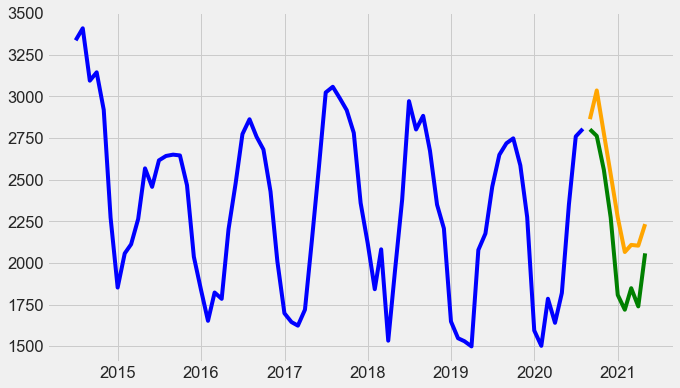

In [426]:
# plotting time series predictions as per GA DSI Lesson 9.03 -- ARIMA
plt.figure(figsize=(10,6))
plt.plot(train.index, pd.DataFrame(train), color = 'blue')
plt.plot(test.index, pd.DataFrame(test), color = 'orange')
plt.plot(test.index, preds, color = 'green');

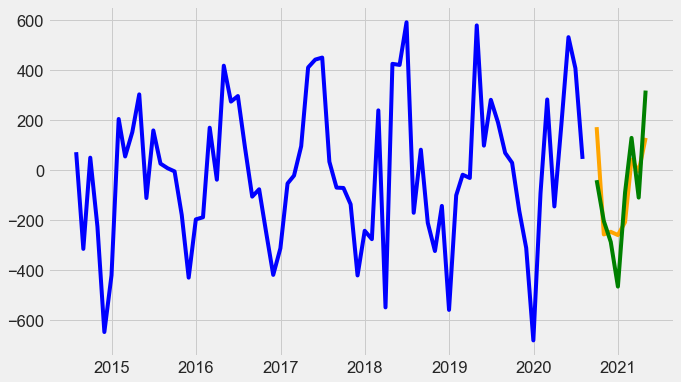

In [427]:
plt.figure(figsize=(10,6))
plt.plot(train.index, pd.DataFrame(train).diff(), color = 'blue')
plt.plot(test.index, pd.DataFrame(test).diff(), color = 'orange')
plt.plot(test.index, preds.diff(), color = 'green');

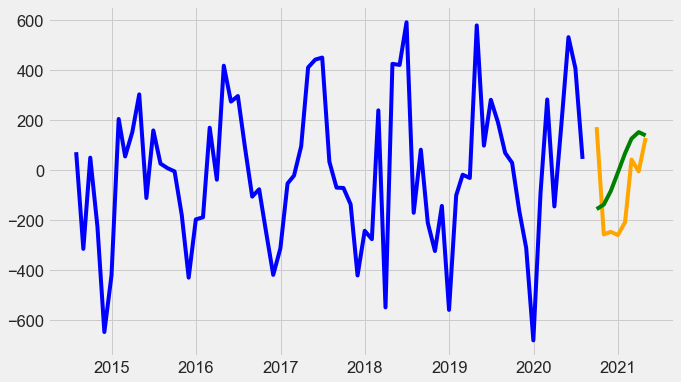

In [428]:
plt.figure(figsize=(10,6))
plt.plot(train.index, pd.DataFrame(train).diff(), color = 'blue')
plt.plot(test.index, pd.DataFrame(test).diff(), color = 'orange')
plt.plot(test.index, arima_preds.diff(), color = 'green');

In [429]:
for i in hydro_regions[hydro_regions['hydrologic_region'] != 'South Lahontan']['hydrologic_region']:
    print(i)

San Francisco Bay
Central Coast
South Coast
San Joaquin River
Sacramento River
Colorado River
North Coast
Tulare Lake
North Lahontan


In [430]:
sc = StandardScaler()
X_train = pd.DataFrame(sc.fit_transform(X_train))
X_test = pd.DataFrame(sc.transform(X_test))

In [431]:
target = 'r_gpcd_2016'
X = conserve.drop(columns=['supplier_name', target, 'hydrologic_region'])
y = conserve[target]

sc = StandardScaler()
X_train = pd.DataFrame(sc.fit_transform(X_train))
X_test = pd.DataFrame(sc.transform(X_test))

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
print("X_train shape:", X_train.shape, "X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape, "y_test shape:", y_test.shape)
lasso_alphas = np.logspace(-2, 2, 50),
lasso_cv = LassoCV(alphas=lasso_alphas, cv=5, max_iter=5000)
lasso_cv.fit(X_train, y_train)

print("LASSO")
preds = lasso_cv.predict(X_test)
print("Best Lasso Train Score:", lasso_cv.score(X_train, y_train))
print("Best Lasso Test Score:", lasso_cv.score(X_test, y_test))
rmse = mean_squared_error(y_test, preds, squared=False)
print("RMSE:", rmse)
# print("RMSE as % of mean SalePrice:", round(100 * rmse / mean_sale_price, 2), "%")
X_test
lasso_coef_df = pd.DataFrame(lasso_cv.coef_, index=X_test.columns, columns=['coefs']).sort_values(by='coefs', ascending=False)
lasso_coef_df

X_train shape: (272, 10) X_test shape: (117, 10)
y_train shape: (272,) y_test shape: (117,)
LASSO
Best Lasso Train Score: 0.6231268050969447
Best Lasso Test Score: 0.6282157112869731
RMSE: 42.74451377051297


,coefs
prev_conserve_standard,5.168922
pct_enforcable_savings,3.092232
monthly_savings_aug_2015,0.891498
current_conserve_standard,0.672054
pop_served,0.000004
self_cert,-0.000000
cumulative_savings,0.000000
missed_standard_by,0.000000
self_cert_2016,-1.316661
monthly_savings_aug_2016,-1.979877


In [432]:
target = 'missed_standard_by'
X = conserve.drop(columns=['supplier_name', target, 'hydrologic_region'])
y = conserve[target]

sc = StandardScaler()
X_train = pd.DataFrame(sc.fit_transform(X_train))
X_test = pd.DataFrame(sc.transform(X_test))

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
print("X_train shape:", X_train.shape, "X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape, "y_test shape:", y_test.shape)
lasso_alphas = np.logspace(-2, 2, 50),
lasso_cv = LassoCV(alphas=lasso_alphas, cv=5, max_iter=5000)
lasso_cv.fit(X_train, y_train)

print("LASSO")
preds = lasso_cv.predict(X_test)
print("Best Lasso Train Score:", lasso_cv.score(X_train, y_train))
print("Best Lasso Test Score:", lasso_cv.score(X_test, y_test))
rmse = mean_squared_error(y_test, preds, squared=False)
print("RMSE:", rmse)
# print("RMSE as % of mean SalePrice:", round(100 * rmse / mean_sale_price, 2), "%")
X_test
lasso_coef_df = pd.DataFrame(lasso_cv.coef_, index=X_test.columns, columns=['coefs']).sort_values(by='coefs', ascending=False)
lasso_coef_df

X_train shape: (272, 10) X_test shape: (117, 10)
y_train shape: (272,) y_test shape: (117,)
LASSO
Best Lasso Train Score: 0.002673885258007158
Best Lasso Test Score: -0.04004297980068183
RMSE: 9.005930882273834


,coefs
pop_served,0.000001
prev_conserve_standard,-0.000000
current_conserve_standard,0.000000
self_cert,-0.000000
pct_enforcable_savings,-0.000000
self_cert_2016,-0.000000
cumulative_savings,-0.000000
monthly_savings_aug_2015,-0.000000
monthly_savings_aug_2016,-0.000000
r_gpcd_2016,-0.000000


In [433]:
water.columns

Index(['climate_zone', 'total_population_served', 'reference_2014_population',
       'water_shortage_contingency_stage_invoked',
       'reported_final_total_potable_water_production',
       'final_percent_residential_use',
       'reported_final_commercial_industrial_and_institutional_water',
       'calculated_total_potable_water_production_gallons_ag_excluded',
       'calculated_total_potable_water_production_gallons_2013_ag_excluded',
       'calculated_commercial_agricultural_water_gallons',
       'calculated_commercial_agricultural_water_gallons_2013',
       'calculated_r_gpcd', 'system_id', 'county_enc', 'hydro_region_enc',
       'reporting_date'],
      dtype='object')

In [434]:
# cols = [
# #     'climate_zone', 'total_population_served', 'reference_2014_population',
# #        'water_shortage_contingency_stage_invoked',
#        'reported_final_total_potable_water_production',
# #        'final_percent_residential_use',
# #        'reported_final_commercial_industrial_and_institutional_water',
#        'calculated_total_potable_water_production_gallons_ag_excluded',
# #        'calculated_total_potable_water_production_gallons_2013_ag_excluded',
#        'calculated_commercial_agricultural_water_gallons',
# #        'calculated_commercial_agricultural_water_gallons_2013',
#        'calculated_r_gpcd', 
# #     'system_id', 'county_enc', 'hydro_region_enc',
# #        'reporting_date'
#        ]
# # @ignore_warnings(category=ConvergenceWarning) 
# # cols = water.columns
# water = water.dropna()
# # cols = water.loc[:, water.columns != ['water_shortage_contingency_stage_invoked', 'reporting_date']].columns
# for i in cols:
#     X = water.drop(columns=['reporting_date', i])
#     y = water[i]

#     X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
# #     sc = StandardScaler()
# #     X_train = pd.DataFrame(sc.fit_transform(X_train))
# #     X_test = pd.DataFrame(sc.transform(X_test))


#     lasso_alphas = np.logspace(-2, 2, 50),
#     lasso_cv = LassoCV(alphas=lasso_alphas, cv=5, max_iter=10000)
#     lasso_cv.fit(X_train, y_train)

#     test_score = lasso_cv.score(X_test, y_test)
#     lasso_coef_df = pd.DataFrame(lasso_cv.coef_, index=X_test.columns, columns=['coefs']).sort_values(by='coefs', ascending=False)
# #     coef_of_interest = lasso_coef_df.loc['water_shortage_contingency_stage_invoked'].values
#     print('------------------------')
# #     print(test_score, coef_of_interest, lasso_coef_df.mean())
#     print(test_score, lasso_coef_df.mean())
#     print('------------------------')

In [435]:
water.columns

Index(['climate_zone', 'total_population_served', 'reference_2014_population',
       'water_shortage_contingency_stage_invoked',
       'reported_final_total_potable_water_production',
       'final_percent_residential_use',
       'reported_final_commercial_industrial_and_institutional_water',
       'calculated_total_potable_water_production_gallons_ag_excluded',
       'calculated_total_potable_water_production_gallons_2013_ag_excluded',
       'calculated_commercial_agricultural_water_gallons',
       'calculated_commercial_agricultural_water_gallons_2013',
       'calculated_r_gpcd', 'system_id', 'county_enc', 'hydro_region_enc',
       'reporting_date'],
      dtype='object')

In [436]:
target = 'calculated_r_gpcd' 
water = water.dropna()
X = water.drop(columns=['reporting_date', target])
y = water[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
print("X_train shape:", X_train.shape, "X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape, "y_test shape:", y_test.shape)
lasso_alphas = np.logspace(-2, 2, 50),
lasso_cv = LassoCV(alphas=lasso_alphas, cv=5, max_iter=5000)
lasso_cv.fit(X_train, y_train)

print("LASSO")
preds = lasso_cv.predict(X_test)
print("Best Lasso Train Score:", lasso_cv.score(X_train, y_train))
print("Best Lasso Test Score:", lasso_cv.score(X_test, y_test))
rmse = mean_squared_error(y_test, preds, squared=False)
print("RMSE:", rmse)

lasso_coef_df = pd.DataFrame(lasso_cv.coef_, index=X_test.columns, columns=['coefs']).sort_values(by='coefs', ascending=False)


X_train shape: (21287, 14) X_test shape: (9124, 14)
y_train shape: (21287,) y_test shape: (9124,)


/Users/rylandmatthews/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20697132.211724095, tolerance: 5351.620353306218
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rylandmatthews/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20388864.90113806, tolerance: 5351.620353306218
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rylandmatthews/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20086787.91232377, tolerance: 5351.620353306218
  model = cd_fast.enet_coordinate_descent_gram(
/Us

/Users/rylandmatthews/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18511994.90033245, tolerance: 5351.620353306218
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rylandmatthews/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18511278.09027538, tolerance: 5351.620353306218
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rylandmatthews/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18510683.09122918, tolerance: 5351.620353306218
  model = cd_fast.enet_coordinate_descent_gram(
/Use

/Users/rylandmatthews/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18689339.509506866, tolerance: 5405.899665760899
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rylandmatthews/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18683154.381346423, tolerance: 5405.899665760899
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rylandmatthews/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18677934.585515752, tolerance: 5405.899665760899
  model = cd_fast.enet_coordinate_descent_gram(
/

/Users/rylandmatthews/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18240751.342737895, tolerance: 5225.741740355755
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rylandmatthews/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18199778.53698923, tolerance: 5225.741740355755
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rylandmatthews/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18164313.314532936, tolerance: 5225.741740355755
  model = cd_fast.enet_coordinate_descent_gram(
/U

/Users/rylandmatthews/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19519768.907331306, tolerance: 5421.876367116674
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rylandmatthews/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19392171.168582123, tolerance: 5421.876367116674
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rylandmatthews/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19272325.770624645, tolerance: 5421.876367116674
  model = cd_fast.enet_coordinate_descent_gram(
/

/Users/rylandmatthews/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20145108.96836474, tolerance: 5429.162324147486
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rylandmatthews/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20039815.50616207, tolerance: 5429.162324147486
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rylandmatthews/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20174005.47641592, tolerance: 5429.162324147486
  model = cd_fast.enet_coordinate_descent_gram(
/Use

/Users/rylandmatthews/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18723582.596722532, tolerance: 5429.162324147486
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rylandmatthews/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18723363.777412783, tolerance: 5429.162324147486
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rylandmatthews/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18723182.349126715, tolerance: 5429.162324147486
  model = cd_fast.enet_coordinate_descent_gram(


LASSO
Best Lasso Train Score: 0.2687018867335831
Best Lasso Test Score: 0.254614432615086
RMSE: 47.69527179953183


/Users/rylandmatthews/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25869583.0636672, tolerance: 6708.6217686017335
  model = cd_fast.enet_coordinate_descent(


In [437]:
lasso_coef_df

,coefs
final_percent_residential_use,6.318532e-01
total_population_served,9.426640e-06
calculated_total_potable_water_production_gallons_ag_excluded,1.017689e-07
calculated_commercial_agricultural_water_gallons_2013,6.059609e-08
calculated_total_potable_water_production_gallons_2013_ag_excluded,1.808310e-10
reported_final_commercial_industrial_and_institutional_water,2.250229e-12
climate_zone,0.000000e+00
water_shortage_contingency_stage_invoked,-0.000000e+00
county_enc,0.000000e+00
hydro_region_enc,0.000000e+00


In [438]:
target = 'reported_final_total_potable_water_production' 
water = water.dropna()
X = water.drop(columns=['reporting_date', target])
y = water[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
print("X_train shape:", X_train.shape, "X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape, "y_test shape:", y_test.shape)
lasso_alphas = np.logspace(-2, 2, 50),
lasso_cv = LassoCV(alphas=lasso_alphas, cv=5, max_iter=5000)
lasso_cv.fit(X_train, y_train)

print("LASSO")
preds = lasso_cv.predict(X_test)
print("Best Lasso Train Score:", lasso_cv.score(X_train, y_train))
print("Best Lasso Test Score:", lasso_cv.score(X_test, y_test))
rmse = mean_squared_error(y_test, preds, squared=False)
print("RMSE:", rmse)
lasso_coef_df = pd.DataFrame(lasso_cv.coef_, index=X_test.columns, columns=['coefs']).sort_values(by='coefs', ascending=False)

/Users/rylandmatthews/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1320419511167326e+28, tolerance: 4.4856154646789304e+24
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rylandmatthews/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.13204182241261e+28, tolerance: 4.4856154646789304e+24
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rylandmatthews/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.132041822001962e+28, tolerance: 4.4856154646789304e+24
  model = cd_fast.enet_co

X_train shape: (21287, 14) X_test shape: (9124, 14)
y_train shape: (21287,) y_test shape: (9124,)


/Users/rylandmatthews/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.132041805886749e+28, tolerance: 4.4856154646789304e+24
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rylandmatthews/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1320418153323383e+28, tolerance: 4.4856154646789304e+24
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rylandmatthews/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.132041810940339e+28, tolerance: 4.4856154646789304e+24
  model = cd_fast.enet_c

/Users/rylandmatthews/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.88834539902848e+28, tolerance: 3.955927925415726e+24
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rylandmatthews/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.888592815133941e+28, tolerance: 3.955927925415726e+24
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rylandmatthews/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.888583411721764e+28, tolerance: 3.955927925415726e+24
  model = cd_fast.enet_coordi

/Users/rylandmatthews/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2515221545086017e+28, tolerance: 4.787887676205446e+24
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rylandmatthews/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2635086150965124e+28, tolerance: 4.787887676205446e+24
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rylandmatthews/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.263521301585148e+28, tolerance: 4.787887676205446e+24
  model = cd_fast.enet_coo

/Users/rylandmatthews/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0422608996092516e+28, tolerance: 4.2960469868074865e+24
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rylandmatthews/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.042260899100354e+28, tolerance: 4.2960469868074865e+24
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rylandmatthews/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0422608886616175e+28, tolerance: 4.2960469868074865e+24
  model = cd_fast.enet_

/Users/rylandmatthews/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.042260713311857e+28, tolerance: 4.2960469868074865e+24
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rylandmatthews/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0422607898766603e+28, tolerance: 4.2960469868074865e+24
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rylandmatthews/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0422607869655093e+28, tolerance: 4.2960469868074865e+24
  model = cd_fast.enet_

/Users/rylandmatthews/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.220367224690478e+28, tolerance: 4.683618652472745e+24
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rylandmatthews/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.220371160387275e+28, tolerance: 4.683618652472745e+24
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rylandmatthews/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2195522898627894e+28, tolerance: 4.683618652472745e+24
  model = cd_fast.enet_coor

LASSO
Best Lasso Train Score: 0.049769172449844024
Best Lasso Test Score: 0.04281199851998285
RMSE: 1565508188707.0544


/Users/rylandmatthews/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.638036068884177e+28, tolerance: 5.552411040347844e+24
  model = cd_fast.enet_coordinate_descent(


In [439]:
lasso_coef_df

,coefs
climate_zone,7.328391e+09
final_percent_residential_use,1.438586e+08
total_population_served,2.474496e+06
system_id,1.075417e+04
calculated_commercial_agricultural_water_gallons,1.002269e+03
calculated_total_potable_water_production_gallons_ag_excluded,3.538570e+01
reported_final_commercial_industrial_and_institutional_water,2.122977e-01
calculated_total_potable_water_production_gallons_2013_ag_excluded,-1.486363e+02
calculated_commercial_agricultural_water_gallons_2013,-4.462255e+02
reference_2014_population,-1.819537e+06


In [440]:
lasso_coef_df.loc['water_shortage_contingency_stage_invoked'].values

array([-1.08324988e+11])